In [1]:
from DL_TFM.scripts.tracNet import TracNet
from DL_TFM.scripts.training_and_evaluation import predictTrac
from DL_TFM.scripts.data_preparation import matFiles_to_npArray, reshape

from scipy.io import savemat, loadmat

import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import keras

2022-10-25 20:55:34.514855: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-10-25 20:55:34.514879: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
random_seed = 2
np.random.seed(random_seed)
torch.manual_seed(random_seed)

# Datasets for TFM

### 1. [Artificial datasets](https://cmu.app.box.com/s/n34hbfopwa3r6rftvtfn4ckc403hk43d) by Wang and Lin 

####  1.1 Training

Three datasets of different resolutions, derived from a cell migration model, were designed for training purposes.

| Category | #Samples | Sample size (h x w x ch) | Young's modulus (N/p) | Labeled (y/n)
| :-: | :-: | :-: | :-: | :-: |
| amoeboid/mesenchymal | 1472 (cells) + 81 (radial patterns) |  104 x 104 x 2 | 10 | y
| amoeboid/mesenchymal | 1472 (cells) + 81 (radial patterns)| 160 x 160 x 2 | 6.5 | y
| amoeboid/mesenchymal | 1472 (cells) + 81 (radial patterns)| 256 x 256 x 2 | 4.1 | y

Additional design choices:
- 184 simulated amoeboid or mesenchymal cells in total (ungrouped)
- each image augmented by seven-fold 45° rotation
- Poisson ratio ν of simulated substrate fixed at 0.45
- from stress fields of size 160 x 160, corresponding fields for other sizes obtained by NN-interpolation
- 81 radial patterns per dataset to enhance resolution and symmetry

Exemplary visualizations of sample `MLData001-00.mat` and radial pattern `MLData160.mat`.

<IPython.core.display.Javascript object>


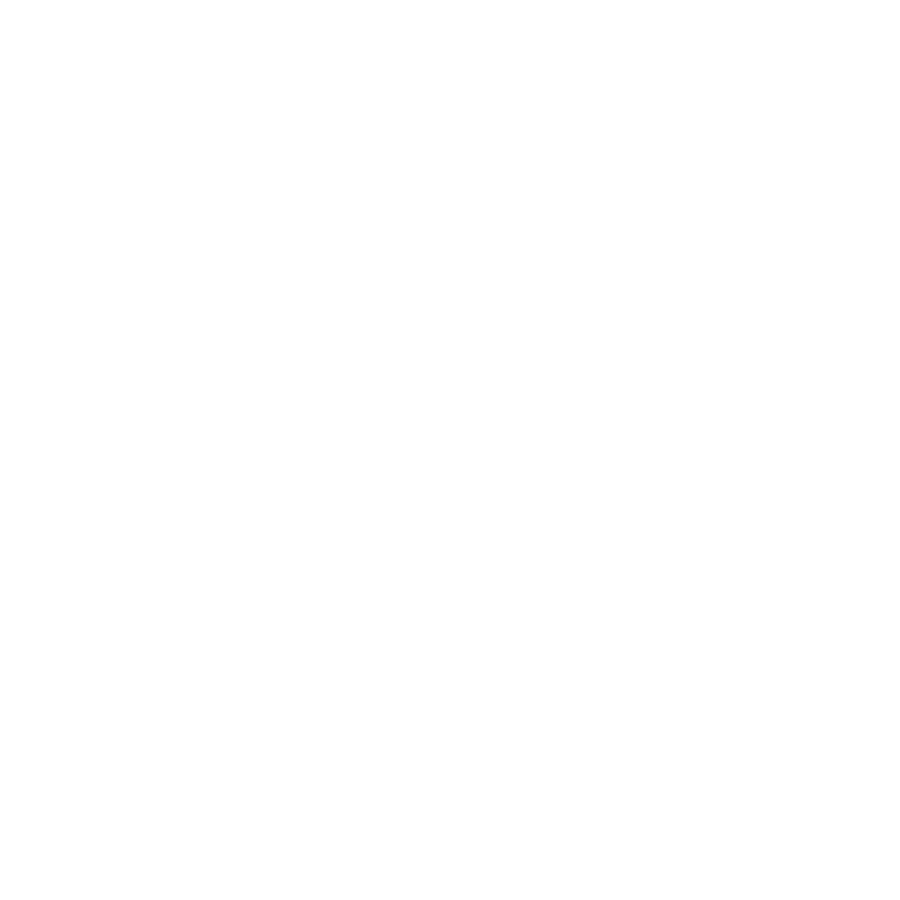

Text(0.5, 1.0, 'MLData160.mat: Radial traction field')

In [3]:
samples = matFiles_to_npArray('comparables/train')

get_ipython().run_line_magic('matplotlib', 'notebook')

fig, axs = plt.subplots(2,2, figsize=(9, 9))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)
axs[0, 0].quiver(samples[2]['dspl'][:,:,0], samples[2]['dspl'][:,:,1], scale=10)
axs[0, 0].set_title('MLData001-00.mat: Displacement', {'fontsize': 11})

C = np.sqrt(samples[2]['dspl'][:,:,0] **2 + samples[2]['dspl'][:,:,1] ** 2)
im = axs[0, 1].pcolormesh(C, cmap='jet', shading='gouraud')
fig.colorbar(im, ax=axs[0, 1])
axs[0, 1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[0, 1].set_title('MLData001-00.mat: Displacement heat map', {'fontsize': 11})

fig.tight_layout(pad=3, w_pad=3, h_pad=3)
axs[1, 0].quiver(samples[3]['trac'][:,:,0], samples[3]['trac'][:,:,1], scale=10)
axs[1, 0].set_title('MLData001-00.mat: Traction', {'fontsize': 11})

C = np.sqrt(samples[0]['trac'][:,:,0] **2 + samples[0]['trac'][:,:,1] ** 2)
im = axs[1, 1].pcolormesh(C, cmap='jet', shading='gouraud')
fig.colorbar(im, ax=axs[1, 1])
axs[1, 1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[1, 1].set_title('MLData160.mat: Radial traction field', {'fontsize': 11})

The training dataset was generated in a physics-informed manner and is of significant size. Furthermore, the complex shapes and forms of the artificial cells imitate those seen in real world experiments. Unfortunately there has been no routine provided to create more cells of this form.

#### 1.2 Tests 

Labeled test data was in principle generated similarly to the training data. Cell types are now grouped and different experimental conditions were mimicked.

| Category | #Samples | Available Sizes (104, 160, 256) | Labeled (y / n) | Description
| :-: | :-: | :-: | :-: | :-: | 
| generic | 17 | 104, 160, 256 | y | generic cell shape
| keratocyte | 10 | 160 | y | keratocyte cell shape
| neuron | 16 | 160 | y | neuron cell shape
| elasticity | 85 | 160 | y | generic cells on substrates with varying ν
| magnification | 17 | 160 | y | varying microscope lenses
| tracScale | 17 | 160 | y | varying stress magnitude

Additional design choices:
- Young's modulus fixed at 10670 Pa (typical for experimental setup)
- maximal stress magnitude set at 6000 Pa (typical for experimental setup)
- Gaussian noise at inference time generated from minimal standard deviation of stress per image

<IPython.core.display.Javascript object>


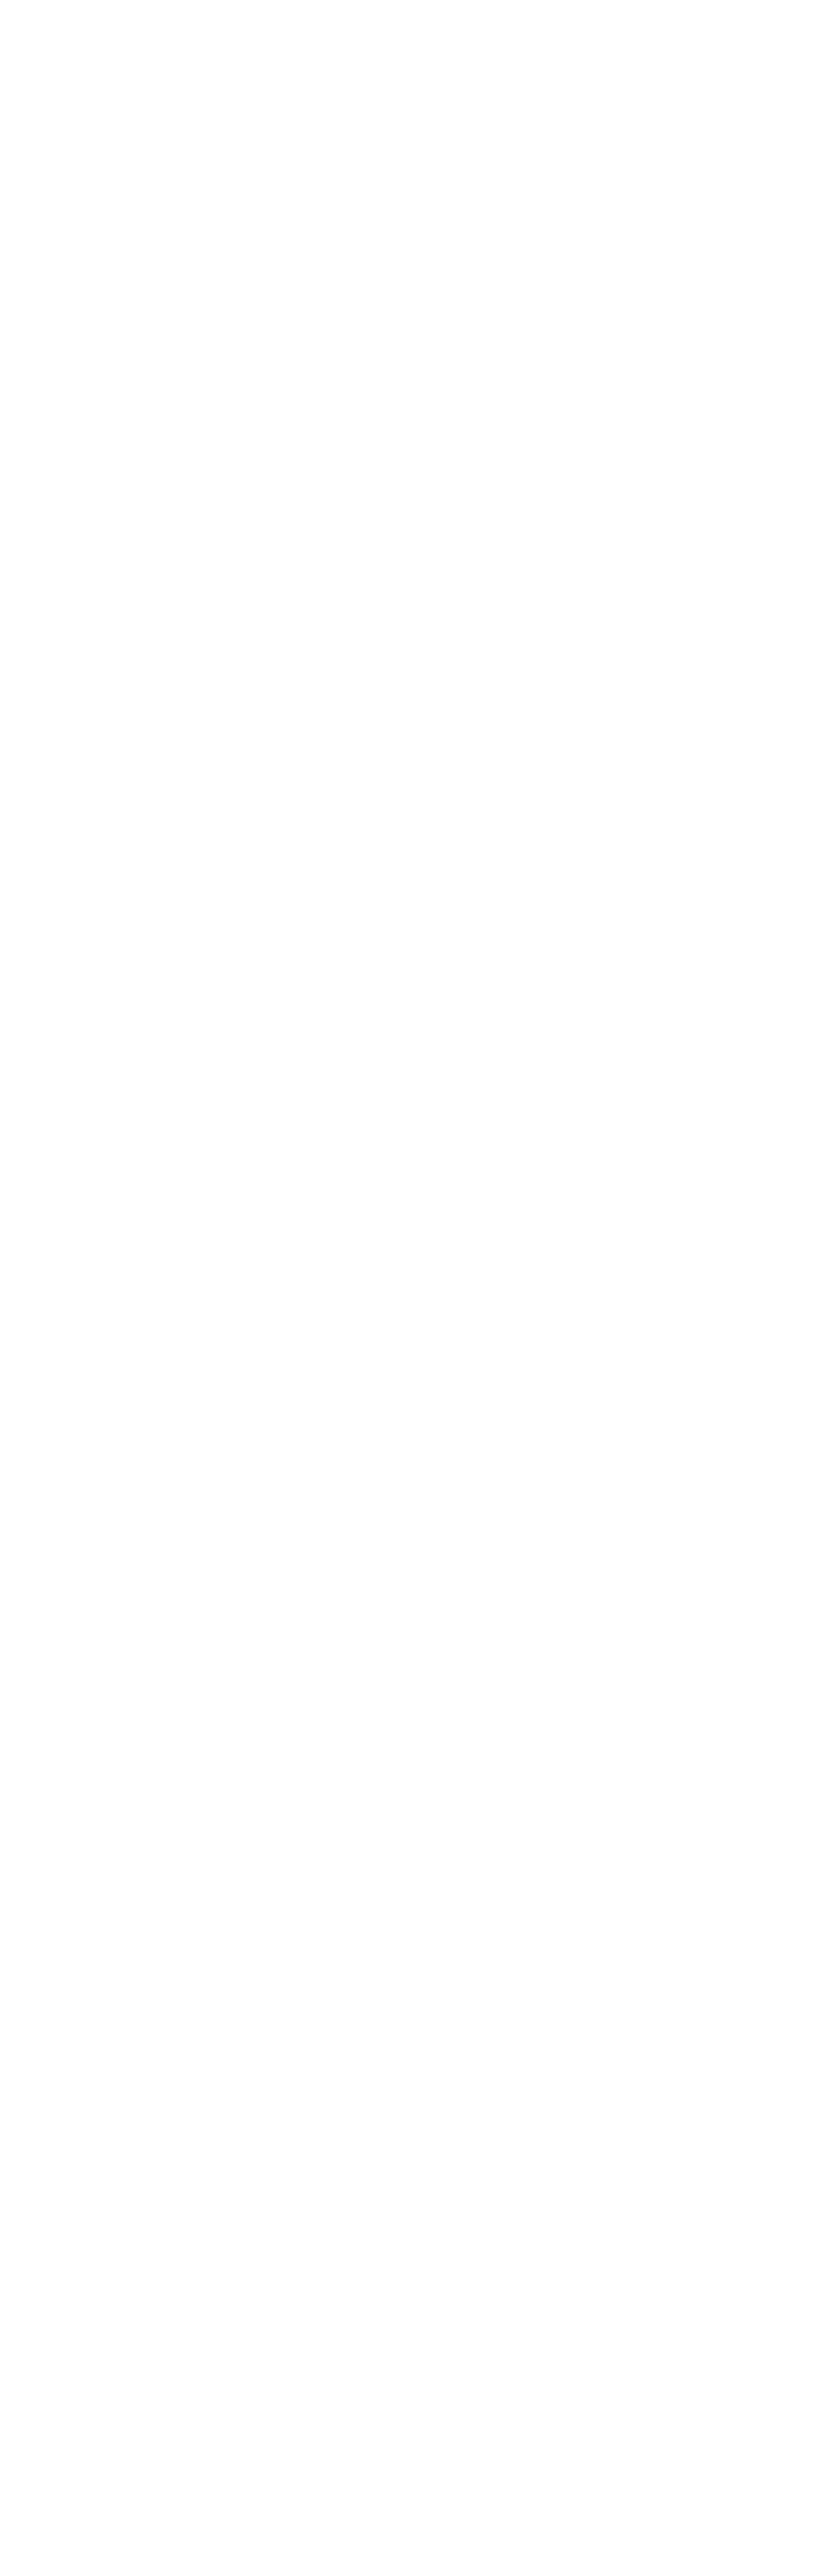

Text(0.5, 1.0, 'Generic cell: Max. stress magnitude = 8000 Pa')

In [4]:
samples_generic = matFiles_to_npArray('comparables/generic')
samples_keratocyte = matFiles_to_npArray('comparables/keratocyte')
samples_neuron = matFiles_to_npArray('comparables/neuron')
samples_elasticity = matFiles_to_npArray('comparables/elasticity')
samples_magnification_small = matFiles_to_npArray('comparables/magnification/S')
samples_magnification_large = matFiles_to_npArray('comparables/magnification/L')
samples_tracScale = matFiles_to_npArray('comparables/tracScale') 

get_ipython().run_line_magic('matplotlib', 'notebook')

fig, axs = plt.subplots(6,2, figsize=(9, 28))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)
axs[0, 0].quiver(samples_generic[1]['dspl'][:,:,0], samples_generic[1]['dspl'][:,:,1], scale=30)
axs[0, 0].set_title('Generic cell: Displacement', {'fontsize': 11})

axs[0, 1].quiver(samples_generic[0]['trac'][:,:,0], samples_generic[0]['trac'][:,:,1], scale=50000)
axs[0, 1].set_title('Generic cell: Traction', {'fontsize': 11})

axs[1, 0].quiver(samples_keratocyte[0]['dspl'][:,:,0], samples_keratocyte[0]['dspl'][:,:,1], scale=30)
axs[1, 0].set_title('Keratocyte: Displacement', {'fontsize': 11})

axs[1, 1].quiver(samples_keratocyte[1]['trac'][:,:,0], samples_keratocyte[1]['trac'][:,:,1], scale=50000)
axs[1, 1].set_title('Keratocyte: Traction', {'fontsize': 11})

axs[2, 0].quiver(samples_neuron[0]['dspl'][:,:,0], samples_neuron[0]['dspl'][:,:,1], scale=30)
axs[2, 0].set_title('Neuron: Displacement', {'fontsize': 11})

axs[2, 1].quiver(samples_neuron[1]['trac'][:,:,0], samples_neuron[1]['trac'][:,:,1], scale=50000)
axs[2, 1].set_title('Neuron: Traction', {'fontsize': 11})

axs[3, 0].quiver(samples_elasticity[0]['dspl'][:,:,0], samples_elasticity[0]['dspl'][:,:,1], scale=30)
axs[3, 0].set_title('Generic cell: Displacement (ν = 2500 Pa)', {'fontsize': 11})

axs[3, 1].quiver(samples_elasticity[1]['dspl'][:,:,0], samples_elasticity[1]['dspl'][:,:,1], scale=30)
axs[3, 1].set_title('Generic cell: Displacement (ν = 20000 Pa)', {'fontsize': 11})

axs[4, 0].quiver(samples_magnification_small[1]['dspl'][:,:,0], samples_magnification_small[1]['dspl'][:,:,1], scale=30)
axs[4, 0].set_title('Generic cell: Displacement (original shrunk by 25%)', {'fontsize': 11})

axs[4, 1].quiver(samples_magnification_large[1]['dspl'][:,:,0], samples_magnification_large[1]['dspl'][:,:,1], scale=30)
axs[4, 1].set_title('Generic cell: Displacement (original enlarged by 25%)', {'fontsize': 11})

axs[5, 0].quiver(samples_tracScale[1]['dspl'][:,:,0], samples_tracScale[1]['dspl'][:,:,1], scale=30)
axs[5, 0].set_title('Generic cell: Max. stress magnitude = 1000 Pa', {'fontsize': 11})

axs[5, 1].quiver(samples_tracScale[0]['dspl'][:,:,0], samples_tracScale[0]['dspl'][:,:,1], scale=30)
axs[5, 1].set_title('Generic cell: Max. stress magnitude = 8000 Pa', {'fontsize': 11})

### 2. [Experimental datasets](https://cmu.app.box.com/s/n34hbfopwa3r6rftvtfn4ckc403hk43d/folder/128446691101) by Wang and Lin 

Measuring substrate displacements exerted by cell forces requires a lengthy and precise experimental setup. The authors therefore only provided 14 preprocessed, unlabeled NIH 3T3 cells.

| Category | #Samples | Available Sizes (104, 160, 256) | Young's modulus (Pa) | Labeled (y/n)
| :-: | :-: | :-: | :-: | :-:
| NIH 3T3 | 14 |  104 x 104 x 2 | 10670 Pa | 0.45

<IPython.core.display.Javascript object>


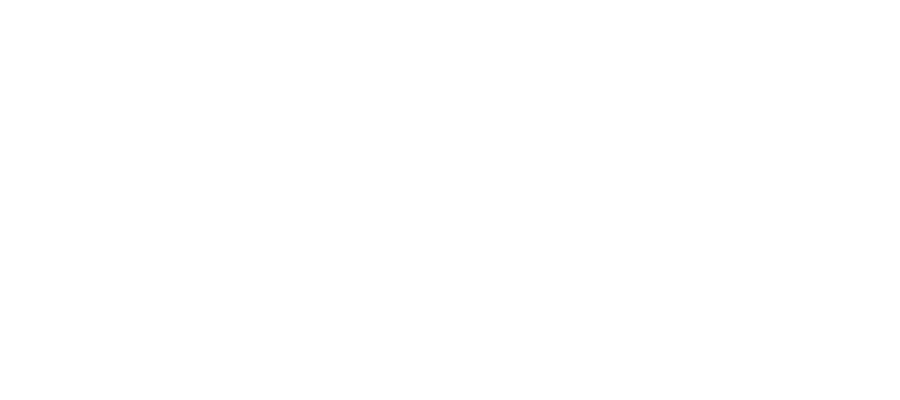

Text(0.5, 1.0, 'MLData001-00.mat: Displacement heat map')

In [5]:
sample = matFiles_to_npArray('comparables/cells') 

get_ipython().run_line_magic('matplotlib', 'notebook')

fig, axs = plt.subplots(1,2, figsize=(9, 4))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)
axs[0].quiver(sample[0]['dspl'][:,:,0], sample[0]['dspl'][:,:,1], scale=10)
axs[0].set_title('MLData001-00.mat: Displacement', {'fontsize': 11})

C = np.sqrt(sample[0]['dspl'][:,:,0] **2 + sample[0]['dspl'][:,:,1] ** 2)
im = axs[1].pcolormesh(C, cmap='jet', shading='gouraud')
fig.colorbar(im, ax=axs[1])
axs[1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[1].set_title('MLData001-00.mat: Displacement heat map', {'fontsize': 11})

Experimental cells are useful for visual analysis of model performance. However, due to a lacking ground truth, a quantitative in-depth analysis is not possible.

### 3. [Artifical data](https://gitlab.tu-dortmund.de/cmt/kierfeld/mltfm) by Kratz et al.

In their paper *Enhancing Robustness, Precision and Speed of Traction Force Microscopy with Machine Learning*, the authors developed a novel data generating process for pairs of displacement and stress fields. They claim their method to be more general (and thus superior for the given and future learning problems) than the one employed by Wang & Lin as they explicitly did not model important characteristics of cellular force patterns.

The corresponding GitLab repository did not contain an explicit dataset, but a function to generate arbitrarily many (input, output)-pairs and noisy corruptions.

Furthermore, the authors provided two traines models, one has been exposed to training data corrupted by low-level background noise and one to the same data corrupted with high-level background noise. Some example visualisations and loss calculations are provided below. Used loss: 

$${MSE} = \frac{1}{M} \sum \limits _{m=1} ^{M} \sum \limits _{(x,y) \in grid} \lvert \textbf{t}_{in,m}(x, y) - \textbf{t}_{out,m}(x, y) \lvert^{2}$$

2022-10-25 20:55:36.511804: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2022-10-25 20:55:36.511845: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (LMVEFVE-WPAR057): /proc/driver/nvidia/version does not exist
2022-10-25 20:55:36.512235: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


<IPython.core.display.Javascript object>


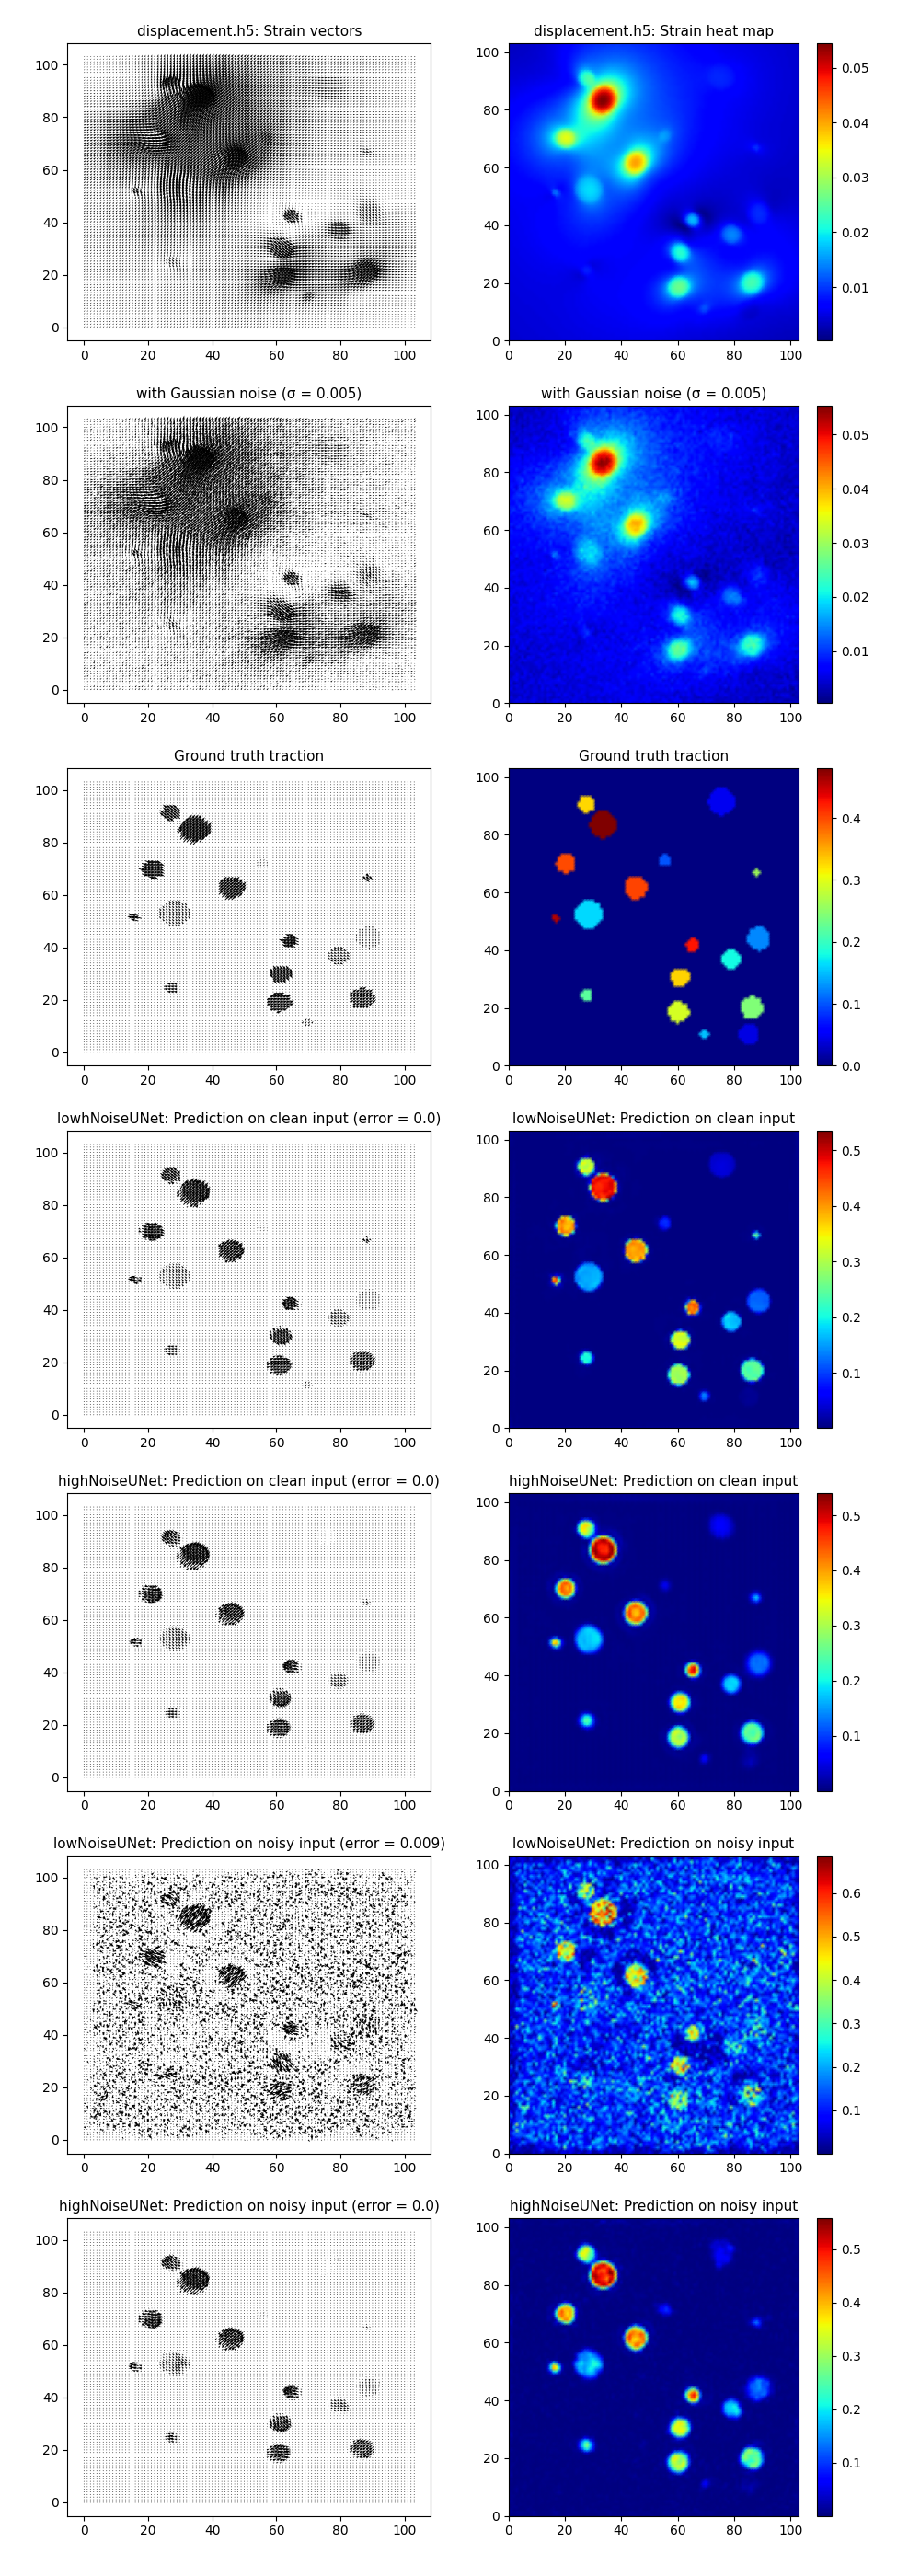

Text(0.5, 1.0, 'highNoiseUNet: Prediction on noisy input')

In [6]:
get_ipython().run_line_magic('matplotlib', 'notebook')

# Load model weights
lowNoiseUNet = keras.models.load_model('comparables/mltfm/models/model_noise_1e-4.h5')
highNoiseUNet = keras.models.load_model('comparables/mltfm/models/model_noise_1e-3.h5')

# Load example data and predict
dspl = h5py.File('comparables/mltfm/displacement.h5')
dspl_noise = h5py.File('comparables/mltfm/displacement_noise.h5')
gt_trac = h5py.File('comparables/mltfm/tractions.h5')

pred_trac_lowNoiseUNet = lowNoiseUNet.predict(dspl['data'])
pred_trac_highNoiseUNet = highNoiseUNet.predict(dspl['data'])
pred_noisy_trac_lowNoiseUNet = lowNoiseUNet.predict(dspl_noise['data'])
pred_noisy_trac_highNoiseUNet = highNoiseUNet.predict(dspl_noise['data'])

loss = torch.nn.MSELoss(reduction='mean')

# Plots
fig, axs = plt.subplots(7,2, figsize=(10, 28))
fig.tight_layout(pad=3, w_pad=3, h_pad=3)
axs[0, 0].quiver(dspl['data'][0,:,:,0], dspl['data'][0,:,:,1], scale=1)
axs[0, 0].set_title('displacement.h5: Strain vectors', {'fontsize': 11})

C = np.sqrt(dspl['data'][0,:,:,0] **2 + dspl['data'][0,:,:,1] ** 2)
im = axs[0, 1].pcolormesh(C, cmap='jet', shading='gouraud')
fig.colorbar(im, ax=axs[0, 1])
axs[0, 1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[0, 1].set_title('displacement.h5: Strain heat map', {'fontsize': 11})

axs[1, 0].quiver(dspl_noise['data'][0,:,:,0], dspl_noise['data'][0,:,:,1], scale=1)
axs[1, 0].set_title('with Gaussian noise (σ = 0.005)', {'fontsize': 11})

C = np.sqrt(dspl_noise['data'][0,:,:,0] **2 + dspl_noise['data'][0,:,:,1] ** 2)
im = axs[1, 1].pcolormesh(C, cmap='jet', shading='gouraud')
fig.colorbar(im, ax=axs[1, 1])
axs[1, 1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[1, 1].set_title('with Gaussian noise (σ = 0.005)', {'fontsize': 11})

axs[2, 0].quiver(gt_trac['data'][0,:,:,0], gt_trac['data'][0,:,:,1], scale=20)
axs[2, 0].set_title('Ground truth traction', {'fontsize': 11})

C = np.sqrt(gt_trac['data'][0,:,:,0] ** 2 + gt_trac['data'][0,:,:,1] ** 2)
im = axs[2,1].pcolormesh(C, cmap='jet', shading='gouraud')
fig.colorbar(im, ax=axs[2,1])
axs[2,1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[2,1].set_title('Ground truth traction', {'fontsize': 11})

error_lowNoiseUNet = loss(torch.tensor(pred_trac_lowNoiseUNet[0,:,:,:]), torch.tensor(gt_trac['data'][0,:,:,:]))
rounded_error_lowNoiseUNet = torch.round(error_lowNoiseUNet, decimals=3)

axs[3, 0].quiver(pred_trac_lowNoiseUNet[0,:,:,0], pred_trac_lowNoiseUNet[0,:,:,1], scale=20)
axs[3, 0].set_title(f'lowhNoiseUNet: Prediction on clean input (error = {rounded_error_lowNoiseUNet})', {'fontsize': 11})

C = np.sqrt(pred_trac_lowNoiseUNet[0,:,:,0] ** 2 + pred_trac_lowNoiseUNet[0,:,:,1] ** 2)
im = axs[3,1].pcolormesh(C, cmap='jet', shading='gouraud')
fig.colorbar(im, ax=axs[3,1])
axs[3,1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[3,1].set_title('lowNoiseUNet: Prediction on clean input', {'fontsize': 11})

error_highNoiseUNet = loss(torch.tensor(pred_trac_highNoiseUNet[0,:,:,:]), torch.tensor(gt_trac['data'][0,:,:,:]))
rounded_error_highNoiseUNet = torch.round(error_highNoiseUNet, decimals=3)

axs[4, 0].quiver(pred_trac_highNoiseUNet[0,:,:,0], pred_trac_highNoiseUNet[0,:,:,1], scale=20)
axs[4, 0].set_title(f'highNoiseUNet: Prediction on clean input (error = {rounded_error_highNoiseUNet})', {'fontsize': 11})

C = np.sqrt(pred_trac_highNoiseUNet[0,:,:,0] ** 2 + pred_trac_highNoiseUNet[0,:,:,1] ** 2)
im = axs[4,1].pcolormesh(C, cmap='jet', shading='gouraud')
fig.colorbar(im, ax=axs[4,1])
axs[4,1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[4,1].set_title('highNoiseUNet: Prediction on clean input', {'fontsize': 11})

error_lowNoiseUNet = loss(torch.tensor(pred_noisy_trac_lowNoiseUNet[0,:,:,:]), torch.tensor(gt_trac['data'][0,:,:,:]))
rounded_error_lowNoiseUNet = torch.round(error_lowNoiseUNet, decimals=3)

axs[5, 0].quiver(pred_noisy_trac_lowNoiseUNet[0,:,:,0], pred_noisy_trac_lowNoiseUNet[0,:,:,1], scale=20)
axs[5, 0].set_title(f'lowNoiseUNet: Prediction on noisy input (error = {rounded_error_lowNoiseUNet})', {'fontsize': 11})

C = np.sqrt(pred_noisy_trac_lowNoiseUNet[0,:,:,0] ** 2 + pred_noisy_trac_lowNoiseUNet[0,:,:,1] ** 2)
im = axs[5,1].pcolormesh(C, cmap='jet', shading='gouraud')
fig.colorbar(im, ax=axs[5,1])
axs[5,1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[5,1].set_title('lowNoiseUNet: Prediction on noisy input', {'fontsize': 11})

error_highNoiseUNet = loss(torch.tensor(pred_noisy_trac_highNoiseUNet[0,:,:,:]), torch.tensor(gt_trac['data'][0,:,:,:]))
rounded_error_highNoiseUNet = torch.round(error_highNoiseUNet, decimals=3)

axs[6, 0].quiver(pred_noisy_trac_highNoiseUNet[0,:,:,0], pred_noisy_trac_highNoiseUNet[0,:,:,1], scale=20)
axs[6, 0].set_title(f'highNoiseUNet: Prediction on noisy input (error = {rounded_error_highNoiseUNet})', {'fontsize': 11})

C = np.sqrt(pred_noisy_trac_highNoiseUNet[0,:,:,0] ** 2 + pred_noisy_trac_highNoiseUNet[0,:,:,1] ** 2)
im = axs[6,1].pcolormesh(C, cmap='jet', shading='gouraud')
fig.colorbar(im, ax=axs[6,1])
axs[6,1].pcolormesh(C, cmap='jet', shading='gouraud')
axs[6,1].set_title('highNoiseUNet: Prediction on noisy input', {'fontsize': 11})